In [2]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

### Essential URLs:
- https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html#_complete_parameter_list
- https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html#_transmission_domain

Link to the API Wrapper I use:
https://github.com/EnergieID/entsoe-py

# ENTSO-E LIBRARY

In [3]:
from entsoe import EntsoePandasClient
import pandas as pd
myToken = "7469cc1c-9765-49b0-9cb1-6385af5ca9e2"   # My API security key

client = EntsoePandasClient(api_key= myToken)      # Starts the link with the API using the library ENTSO E Pandas Client

# Malta and Cyprus have been removed due to lack of data.
# Countries with no values for 2019: Malta, Cyprus, Albania
countryCodes = {'Austria': 'AT', 'Belgium': 'BE', 'Bulgaria': 'BG', 'Croatia': 'HR', 'Czechia': 'CZ', 'Denmark': 'DK', 'Estonia': 'EE', 'Finland': 'FI', 'France': 'FR', 'Germany': 'DE', 'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Latvia': 'LV', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Romania': 'RO', 'Serbia': 'RS', 'Slovakia': 'SK', 'Slovenia': 'SI', 'Spain': 'ES', 'Sweden': 'SE', 'Switzerland': 'CH', 'United Kingdom': 'UK'}

# Gather all types of generation data.
generationType = ['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Fossil Oil shale', 'Peat', 'Geothermal', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore']


In [4]:
genTypeEmissions = {
    'Biomass'                         : 230,
    'Brown coal/Lignite'              : 954*1.05,
    'Coal-derived gas'                : 954,
    'Gas'                             : 600,
    'Hard coal'                       : 954,
    'Fossil Oil'                      : 1125,
    'Fossil Oil shale'                : 1125,
    'Peat'                            : 230, 
    'Geothermal'                      : 38, 
    'Hydro Pumped Storage'            : 44,
    'Hydro Run-of-river and poundage' : 11,
    'Hydro Water Reservoir'           : 11, 
    'Marine'                          : 50, 
    'Nuclear'                         : 5, 
    'Other renewable'                 : 10, 
    'Solar'                           : 35, 
    'Waste'                           : 230, 
    'Wind Offshore'                   : 11, 
    'Wind Onshore'                    : 11,
}

genTypeEmissions = {
    'Biomass'                         : 230,
    'Coal'                            : 1000,
    'Gas'                             : 600,
    'Hydro'                           : 11, 
    'Nuclear'                         : 5, 
    'Solar'                           : 35, 
    'Wind'                            : 11, 
}

In [5]:
# Days of data gathering

jun21    = 20190621
startJun = pd.Timestamp(str(jun21), tz='Europe/Berlin')
endJun   = pd.Timestamp(str(jun21+1), tz='Europe/Berlin')

dec21    = 20191221
startDec = pd.Timestamp(str(dec21), tz='Europe/Berlin')
endDec   = pd.Timestamp(str(dec21+1), tz='Europe/Berlin')

mar21    = 20190321
startMar = pd.Timestamp(str(mar21), tz='Europe/Berlin')
endMar   = pd.Timestamp(str(mar21+1), tz='Europe/Berlin')

sep21    = 20190921
startSep = pd.Timestamp(str(sep21), tz='Europe/Berlin')
endSep   = pd.Timestamp(str(sep21+1), tz='Europe/Berlin')

In [11]:
def get_LG_data(code, start, end, nett = True):
    '''
    Input: 
        - Code: 2-letter country code (str)
        - start0, end0: date range    (pd.Timestamp)
        - nett: boolean, condenses generation and consumption of a plant into a net number. True by default.
    Output:
        - Timeseries DataFrame with 21 columns containing in order, the day-ahead prices, the load and the generation 
          for a given country. Data is resampled hourly (24 rows).
    '''
    
    ts1 = client.query_load(code, start=start, end=end)    # Gets load data for one country
    ts2 = client.query_generation(code, start=start, end=end, nett = True) # Gets generation data
    
    if code == 'DK':
        ts31 = client.query_day_ahead_prices('DK_1', start=start, end=end) 
        ts32 = client.query_day_ahead_prices('DK_2', start=start, end=end) 
        ts3 = (ts31 + ts32) / 2
    elif code == "SE":
        ts31 = client.query_day_ahead_prices('SE_1', start=start, end=end) 
        ts32 = client.query_day_ahead_prices('SE_2', start=start, end=end)
        ts33 = client.query_day_ahead_prices('SE_3', start=start, end=end)
        ts34 = client.query_day_ahead_prices('SE_4', start=start, end=end)
        ts3 = (ts31 + ts32 + ts33 + ts34) / 4
    elif code == "NO":
        ts31 = client.query_day_ahead_prices('NO_1', start=start, end=end) 
        ts32 = client.query_day_ahead_prices('NO_2', start=start, end=end)
        ts33 = client.query_day_ahead_prices('NO_3', start=start, end=end)
        ts34 = client.query_day_ahead_prices('NO_4', start=start, end=end)
        ts35 = client.query_day_ahead_prices('NO_5', start=start, end=end)
        ts3 = (ts31 + ts32 + ts33 + ts34 + ts35) / 5
    elif code == "IT":
        ts31 = client.query_day_ahead_prices('IT_NORD', start=start, end=end)
        ts32 = client.query_day_ahead_prices('IT_CNOR', start=start, end=end)
        ts33 = client.query_day_ahead_prices('IT_CSUD', start=start, end=end)
        ts34 = client.query_day_ahead_prices('IT_SUD', start=start, end=end)
        ts3 = (ts31 + ts32 + ts33 + ts34) / 4
    elif code in ['DE', 'LU']: 
        ts3 = client.query_day_ahead_prices('DE_LU', start=start, end=end)
    elif code == 'IE':
        ts3 = client.query_day_ahead_prices('IE_SEM', start=start, end=end)
    elif code == 'UK':
        ts3 = client.query_day_ahead_prices('GB', start=start, end=end)
    else:
        ts3 = client.query_day_ahead_prices(code, start=start, end=end)
    for genT in generationType:
        if genT not in list(ts2.columns):
            ts2[genT] = 0                  # eg If a country does not have "nuclear", add the column anyway as zeros
    date_range = pd.date_range(start=start, end=end, freq='H')
    # Create an empty DataFrame with this date range as the index
    ts2_bis = pd.DataFrame(index=date_range)
    
    for aggrGenType, genTypeList in actualGenTypes.items():
            tot = sum([ts2[genT] for genT in genTypeList])
            ts2_bis[aggrGenType] = tot
    ts2 = ts2_bis
    ts2.insert(0, 'Day-ahead Prices', ts3)
    ts2.insert(1, 'Load', ts1)             # I just put load and gen data in the same dataframe, load being the first column
    ts2 = ts2.resample('H').first()        # depending on the country, data is every 15min or every hour. Resamples to every hour
    return ts2

actualGenTypes = {"Wind"    : ['Wind Offshore','Wind Onshore'],
                  "Solar"   : ['Solar'], 
                  "Hydro"   : ['Hydro Pumped Storage','Hydro Run-of-river and poundage', 'Hydro Water Reservoir'], 
                  "Nuclear" : ['Nuclear'], 
                  "Gas"     : ['Fossil Gas'], 
                  "Coal"    : ['Fossil Hard coal','Fossil Oil','Fossil Brown coal/Lignite', 'Fossil Oil shale', 'Fossil Coal-derived gas'],
                  "Biomass" : ['Biomass', 'Waste', 'Peat']
                }

def get_gen_cap(code, start0, end0):
    '''
    Input: 
        - Code: 2-letter country code (str)
        - start0, end0: date range    (pd.Timestamp)
    Output:
        - Pandas.DataFrame containing the installd generation capacity for each type at the given data. Granularity is yearly
    '''
    try:
        ts = client.query_installed_generation_capacity(code, start=start0, end=end0, psr_type=None)
        for genT in generationType:
            if genT not in list(ts.columns):
                ts[genT] = 0                  # eg If a country does not have "nuclear", add the column anyway as zeros
        ts2 = {}
        for aggrGenType, genTypeList in actualGenTypes.items():
            tot = sum([ts[genT].iloc[0] for genT in genTypeList])
            ts2[aggrGenType] = tot        
        return ts, ts2
    except Exception as exc:
        print(f"Exception of type {type(exc).__name__}")
        #Make up some random data. Issue is prices are per bidding zone, not country
        print(code)
        return None, None

def get_LG_allCountries(start, end):
    countryData = {}
    for country, code in countryCodes.items():
        print(country)
        countryData[country] = get_LG_data(code, start, end)
    return countryData

def get_genCap_allCountries(start, end):
    countryGenCap = {}
    aggrCountryGenCap = {}
    for country, code in countryCodes.items():
        print(country)
        dic1, dic2 = get_gen_cap(code, start, end)
        countryGenCap[country] = dic1
        aggrCountryGenCap[country] = dic2
    return countryGenCap, aggrCountryGenCap

# LOAD FACTORS FOR 2023

In [21]:
ts = client.query_installed_generation_capacity('10YIE-1001A00010', start=startJunb, end=endJunb, psr_type=None)

display(ts)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [17]:
# Days of data gathering

jun21b    = 20230621
startJunb = pd.Timestamp(str(jun21b), tz='Europe/Berlin')
endJunb   = pd.Timestamp(str(jun21b+1), tz='Europe/Berlin')

dec21b    = 20221221
startDecb = pd.Timestamp(str(dec21b), tz='Europe/Berlin')
endDecb   = pd.Timestamp(str(dec21b+1), tz='Europe/Berlin')

mar21b    = 20230321
startMarb = pd.Timestamp(str(mar21b), tz='Europe/Berlin')
endMarb   = pd.Timestamp(str(mar21b+1), tz='Europe/Berlin')

sep21b    = 20230921
startSepb = pd.Timestamp(str(sep21b), tz='Europe/Berlin')
endSepb   = pd.Timestamp(str(sep21b+1), tz='Europe/Berlin')
'''
countryGenCap, aggrCountryGenCap = get_genCap_allCountries(startJunb, endJunb)

countryData_junb = get_LG_allCountries(startJunb, endJunb)
print("Done for June.")
countryData_decb = get_LG_allCountries(startDecb, endDecb)
print("Done for December.")
countryData_marb = get_LG_allCountries(startMarb, endMarb)
print("Done for March.")
countryData_sepb = get_LG_allCountries(startSepb, endSepb)
print("Done for September.")'''

'\ncountryGenCap, aggrCountryGenCap = get_genCap_allCountries(startJunb, endJunb)\n\ncountryData_junb = get_LG_allCountries(startJunb, endJunb)\nprint("Done for June.")\ncountryData_decb = get_LG_allCountries(startDecb, endDecb)\nprint("Done for December.")\ncountryData_marb = get_LG_allCountries(startMarb, endMarb)\nprint("Done for March.")\ncountryData_sepb = get_LG_allCountries(startSepb, endSepb)\nprint("Done for September.")'

In [ ]:
#countryData = {}
capacityFactor_wind = {}
capacityFactor_solar = {}
for country in list(countryCodes.keys()):
    
    #countryData[country] = pd.concat([countryData_mar[country], countryData_jun[country], countryData_sep[country], countryData_dec[country]])
    wind_capacity = aggrCountryGenCap[country]["Wind"]
    solar_capacity = aggrCountryGenCap[country]["Solar"]
    
    capacityFactor_wind[country]  = countryData[country]["Wind"] / wind_capacity   if wind_capacity  != 0 else countryData[country]["Wind"]*0
    capacityFactor_solar[country] = countryData[country]["Solar"] / solar_capacity if solar_capacity != 0 else countryData[country]["Solar"]*0
    

# Gets Generation Capacity for each country

In [82]:
countryGenCap, aggrCountryGenCap = get_genCap_allCountries(startJun, endJun)

Austria
Belgium
Bulgaria
Croatia
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Netherlands
Norway
Poland
Portugal
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom


In [86]:
display(aggrCountryGenCap['Germany'])

with open('aggregatedGenCapacity.pkl', 'wb') as f:
    pickle.dump(aggrCountryGenCap, f)

{'Wind': 59185.0,
 'Solar': 45299.0,
 'Hydro': 14703.0,
 'Nuclear': 9516.0,
 'Gas': 31664.0,
 'Coal': 50854.0,
 'Biomass': 9438.0}

In [8]:
with open('aggregatedGenCapacity.pkl', 'rb') as f:
    d = pickle.load(f)

display(d['Switzerland'])

{'Wind': 0,
 'Solar': 0,
 'Hydro': 12695.0,
 'Nuclear': 3373.0,
 'Gas': 0,
 'Coal': 0,
 'Biomass': 0}

# Country Generation and Load data

In [105]:
# Puts the gen/load data for each country in a dictionnary, 1 equals June 21 and 2 = December 21, 2019

countryData_jun = get_LG_allCountries(startJun, endJun)
print("Done for June.")
countryData_dec = get_LG_allCountries(startDec, endDec)
print("Done for December.")
countryData_mar = get_LG_allCountries(startMar, endMar)
print("Done for March.")
countryData_sep = get_LG_allCountries(startSep, endSep)
print("Done for September.")


Austria
Belgium
Bulgaria
Croatia
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Netherlands
Norway
Poland
Portugal
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom
Done for December.
Austria
Belgium
Bulgaria
Croatia
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Netherlands
Norway
Poland
Portugal
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom
Done for March.
Austria
Belgium
Bulgaria
Croatia
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Netherlands
Norway
Poland
Portugal
Romania
Serbia
Slovakia
Slovenia
Spain
Sweden
Switzerland
United Kingdom
Done for September.


In [108]:
countryData_mar = countryData_mar["France"][:-1]
countryData_jun = countryData_jun["France"][:-1]
countryData_sep = countryData_sep["France"][:-1]
countryData_dec = countryData_dec["France"][:-1]

,Day-ahead Prices,Load,Wind,Solar,Hydro,Nuclear,Gas,Coal,Biomass
2019-03-21 00:00:00+01:00,35.47,59079.0,1887.0,0.0,6824.0,48250.0,7351.0,180.0,560.0
2019-03-21 01:00:00+01:00,34.70,57536.0,1785.0,0.0,5843.0,48106.0,6871.0,180.0,563.0
2019-03-21 02:00:00+01:00,33.51,56382.0,1780.0,0.0,5110.0,48133.0,6611.0,180.0,563.0
2019-03-21 03:00:00+01:00,33.04,54029.0,1733.0,0.0,4556.0,48009.0,6357.0,180.0,561.0
2019-03-21 04:00:00+01:00,33.10,53593.0,1773.0,0.0,4583.0,48032.0,6360.0,181.0,563.0
2019-03-21 05:00:00+01:00,35.93,56591.0,1907.0,0.0,5633.0,48257.0,6976.0,181.0,562.0
2019-03-21 06:00:00+01:00,44.04,62457.0,1978.0,128.0,8854.0,48472.0,7180.0,181.0,560.0
2019-03-21 07:00:00+01:00,47.71,66531.0,2001.0,499.0,10829.0,48496.0,7241.0,181.0,560.0
2019-03-21 08:00:00+01:00,45.09,67042.0,1657.0,1963.0,9996.0,48415.0,7129.0,181.0,558.0
2019-03-21 09:00:00+01:00,42.94,65603.0,1118.0,3652.0,8818.0,48266.0,7029.0,183.0,556.0


,Day-ahead Prices,Load,Wind,Solar,Hydro,Nuclear,Gas,Coal,Biomass
2019-06-21 00:00:00+02:00,34.30,44427.0,1584.0,0.0,8363.0,40825.0,3335.0,163.0,485.0
2019-06-21 01:00:00+02:00,30.47,41469.0,1665.0,0.0,6722.0,40617.0,2426.0,162.0,486.0
2019-06-21 02:00:00+02:00,27.21,40058.0,1718.0,0.0,6092.0,40327.0,1734.0,162.0,484.0
2019-06-21 03:00:00+02:00,19.76,37790.0,1732.0,0.0,5173.0,39590.0,1652.0,161.0,484.0
2019-06-21 04:00:00+02:00,17.91,36956.0,1782.0,0.0,4772.0,38964.0,1665.0,160.0,485.0
2019-06-21 05:00:00+02:00,24.39,38208.0,1778.0,219.0,4941.0,39554.0,1840.0,160.0,484.0
2019-06-21 06:00:00+02:00,26.61,41485.0,1714.0,297.0,6379.0,40790.0,2896.0,162.0,485.0
2019-06-21 07:00:00+02:00,31.98,46154.0,1517.0,636.0,8284.0,41196.0,3981.0,163.0,485.0
2019-06-21 08:00:00+02:00,47.09,49263.0,1018.0,1323.0,10220.0,41245.0,4581.0,162.0,483.0
2019-06-21 09:00:00+02:00,44.41,51000.0,906.0,2209.0,11072.0,41369.0,4467.0,163.0,484.0


,Day-ahead Prices,Load,Wind,Solar,Hydro,Nuclear,Gas,Coal,Biomass
2019-09-21 00:00:00+02:00,33.07,42115.0,7153.0,0.0,1373.0,36320.0,2986.0,166.0,528.0
2019-09-21 01:00:00+02:00,26.94,39160.0,6926.0,0.0,765.0,36256.0,1902.0,170.0,527.0
2019-09-21 02:00:00+02:00,22.91,37579.0,6610.0,0.0,171.0,35939.0,1343.0,170.0,521.0
2019-09-21 03:00:00+02:00,17.10,35327.0,6235.0,0.0,-676.0,35004.0,1294.0,169.0,518.0
2019-09-21 04:00:00+02:00,15.79,34296.0,5987.0,0.0,-685.0,34236.0,1305.0,169.0,518.0
2019-09-21 05:00:00+02:00,15.78,34657.0,5873.0,0.0,-630.0,34336.0,1328.0,169.0,510.0
2019-09-21 06:00:00+02:00,19.29,36321.0,5710.0,0.0,-220.0,35252.0,1379.0,170.0,510.0
2019-09-21 07:00:00+02:00,20.42,37617.0,5768.0,130.0,981.0,35786.0,1692.0,170.0,510.0
2019-09-21 08:00:00+02:00,27.89,39819.0,5497.0,495.0,1899.0,36858.0,2951.0,170.0,509.0
2019-09-21 09:00:00+02:00,36.50,42579.0,4598.0,1447.0,2990.0,37299.0,3163.0,170.0,504.0


,Day-ahead Prices,Load,Wind,Solar,Hydro,Nuclear,Gas,Coal,Biomass
2019-12-21 00:00:00+01:00,18.11,55849.0,6611.0,0.0,10052.0,43650.0,2358.0,206.0,552.0
2019-12-21 01:00:00+01:00,13.99,53729.0,6434.0,0.0,7953.0,43026.0,2351.0,206.0,553.0
2019-12-21 02:00:00+01:00,10.00,51194.0,6341.0,0.0,6157.0,42291.0,2354.0,205.0,557.0
2019-12-21 03:00:00+01:00,9.15,48926.0,6150.0,0.0,4812.0,40983.0,2357.0,202.0,557.0
2019-12-21 04:00:00+01:00,7.82,48057.0,6295.0,0.0,4748.0,41274.0,2335.0,202.0,556.0
2019-12-21 05:00:00+01:00,12.83,48922.0,6722.0,0.0,5264.0,41587.0,2342.0,202.0,554.0
2019-12-21 06:00:00+01:00,21.36,50881.0,7040.0,0.0,5993.0,42765.0,2355.0,201.0,555.0
2019-12-21 07:00:00+01:00,27.48,53167.0,7417.0,0.0,9744.0,43179.0,2363.0,204.0,556.0
2019-12-21 08:00:00+01:00,29.57,55717.0,7662.0,170.0,12249.0,45188.0,2339.0,206.0,555.0
2019-12-21 09:00:00+01:00,29.31,57222.0,7627.0,764.0,12597.0,45696.0,2366.0,206.0,557.0


In [39]:
pd.set_option('display.max_rows', 100)

with open('aggregatedGenCapacity.pkl', 'rb') as f:
    aggrCountryGenCap = pickle.load(f)
    
with open('countryData.pkl', 'rb') as f:
    countryData = pickle.load(f)

In [41]:
#countryData = {}
capacityFactor_wind = {}
capacityFactor_solar = {}
for country in list(countryCodes.keys()):
    
    #countryData[country] = pd.concat([countryData_mar[country], countryData_jun[country], countryData_sep[country], countryData_dec[country]])
    wind_capacity = aggrCountryGenCap[country]["Wind"]
    solar_capacity = aggrCountryGenCap[country]["Solar"]
    
    capacityFactor_wind[country]  = countryData[country]["Wind"] / wind_capacity   if wind_capacity  != 0 else countryData[country]["Wind"]*0
    capacityFactor_solar[country] = countryData[country]["Solar"] / solar_capacity if solar_capacity != 0 else countryData[country]["Solar"]*0
    

In [131]:
s = 0
for country in list(countryCodes.keys()):
    s += 1
    print(country, " ", len(countryData[country]))
print(s)
display(countryData)

Austria   96
Belgium   96
Bulgaria   96
Croatia   96
Czechia   96
Denmark   96
Estonia   96
Finland   96
France   96
Germany   96
Greece   96
Hungary   96
Ireland   96
Italy   96
Latvia   96
Lithuania   96
Luxembourg   96
Netherlands   96
Norway   96
Poland   96
Portugal   96
Romania   96
Serbia   96
Slovakia   96
Slovenia   96
Spain   96
Sweden   96
Switzerland   96
United Kingdom   96
29


{'Austria':                            Day-ahead Prices    Load    Wind  Solar   Hydro  \
 2019-03-21 00:00:00+01:00             35.47  6877.0   192.0    0.0  4396.0   
 2019-03-21 01:00:00+01:00             34.70  6607.0   200.0    0.0  4242.0   
 2019-03-21 02:00:00+01:00             33.51  6478.0   252.0    0.0  4046.0   
 2019-03-21 03:00:00+01:00             33.04  6356.0   264.0    0.0  3800.0   
 2019-03-21 04:00:00+01:00             33.10  6424.0   216.0    0.0  4052.0   
 2019-03-21 05:00:00+01:00             35.93  6888.0   184.0    0.0  4246.0   
 2019-03-21 06:00:00+01:00             44.03  7792.0   184.0    4.0  5242.0   
 2019-03-21 07:00:00+01:00             46.68  8792.0   132.0   36.0  6478.0   
 2019-03-21 08:00:00+01:00             44.97  9003.0    60.0  100.0  6154.0   
 2019-03-21 09:00:00+01:00             41.87  8778.0     4.0  172.0  5147.0   
 2019-03-21 10:00:00+01:00             38.50  8764.0     4.0  220.0  4533.0   
 2019-03-21 11:00:00+01:00             35

In [44]:
with open('countryData.pkl', 'wb') as f:
    pickle.dump(countryData, f)

with open('capacityFactor_wind.pkl', 'wb') as f:
    pickle.dump(capacityFactor_wind, f)
    
with open('capacityFactor_solar.pkl', 'wb') as f:
    pickle.dump(capacityFactor_solar, f)

Estonia
Estonia
Estonia
Estonia
Estonia
Estonia
France
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Finland
Estonia
Estonia
Finland
Estonia


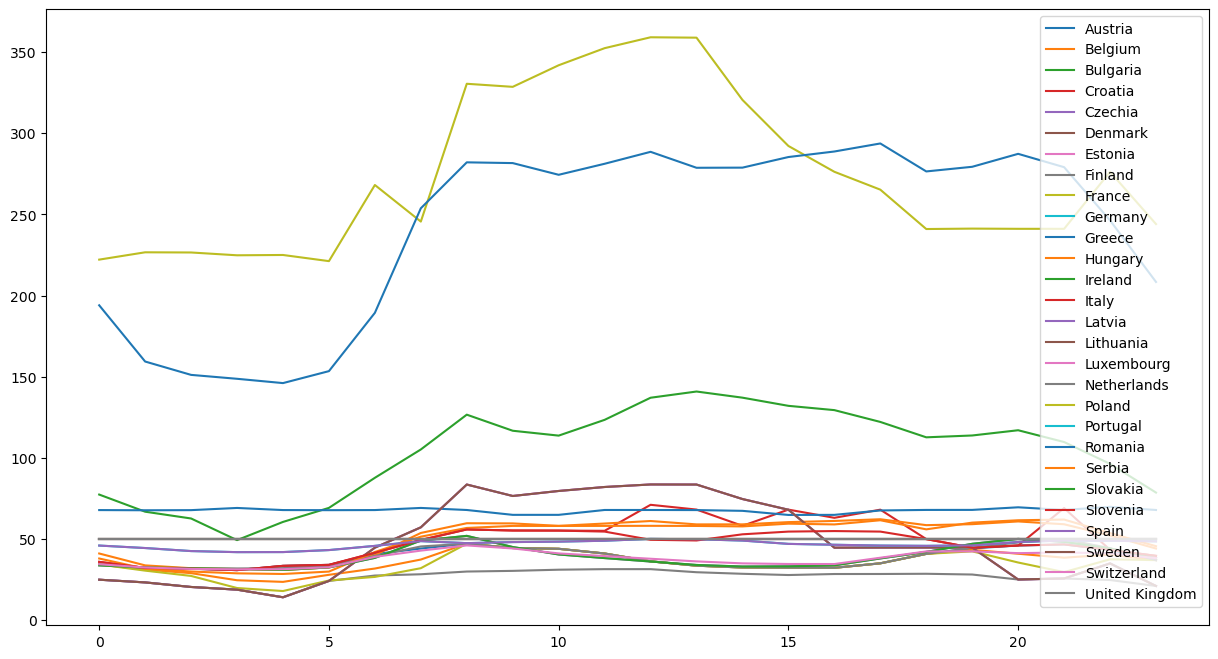

In [14]:
# LOAD A PICKLE FILE
import numpy as np

with open('countryData1b.pkl', 'rb') as f:
    countryData1 = pickle.load(f)
    
with open('countryData2b.pkl', 'rb') as f:
    countryData2 = pickle.load(f)
    
fig, ax = plt.subplots(figsize=(15, 8))
x = [i for i in range(24)]

for i in countryData1:
    #print(i)
    ax.plot(x, countryData1[i]['Day-ahead Prices'], label = i)
    
for i in x:
    l = [countryData1[k]['Day-ahead Prices'].iloc[i] for k in countryData1.keys()]
    #print(l)
    p = min(l)
    ind = np.argmin(l)
    country = list(countryData1.keys())[ind]
    print(country)
    #print(p, ind)
    
plt.legend()

In [ ]:
NEIGHBOURS = {
    'BE': ['NL', 'DE_AT_LU', 'FR', 'GB', 'DE_LU'],
    'NL': ['BE', 'DE_AT_LU', 'DE_LU', 'GB', 'NO_2', 'DK_1'],
    'DE_AT_LU': ['BE', 'CH', 'CZ', 'DK_1', 'DK_2', 'FR', 'IT_NORD', 'IT_NORD_AT', 'NL', 'PL', 'SE_4', 'SI'],
    'FR': ['BE', 'CH', 'DE_AT_LU', 'DE_LU', 'ES', 'GB', 'IT_NORD', 'IT_NORD_FR'],
    'CH': ['AT', 'DE_AT_LU', 'DE_LU', 'FR', 'IT_NORD', 'IT_NORD_CH'],
    'AT': ['CH', 'CZ', 'DE_LU', 'HU', 'IT_NORD', 'SI'],
    'CZ': ['AT', 'DE_AT_LU', 'DE_LU', 'PL', 'SK'],
    'GB': ['BE', 'FR', 'IE_SEM', 'NL', 'NO_2'],
    'NO_2': ['DE_LU', 'DK_1', 'NL', 'NO_1', 'NO_5', 'GB'],
    'HU': ['AT', 'HR', 'RO', 'RS', 'SK', 'UA'],
    'IT_NORD': ['CH', 'DE_AT_LU', 'FR', 'SI', 'AT', 'IT_CNOR'],
    'ES': ['FR', 'PT'],
    'SI': ['AT', 'DE_AT_LU', 'HR', 'IT_NORD'],
    'RS': ['AL', 'BA', 'BG', 'HR', 'HU', 'ME', 'MK', 'RO'],
    'PL': ['CZ', 'DE_AT_LU', 'DE_LU', 'LT', 'SE_4', 'SK', 'UA'],
    'ME': ['AL', 'BA', 'RS'],
    'DK_1': ['DE_AT_LU', 'DE_LU', 'DK_2', 'NO_2', 'SE_3', 'NL'],
    'RO': ['BG', 'HU', 'RS', 'UA'],
    'LT': ['BY', 'LV', 'PL', 'RU_KGD', 'SE_4'],
    'BG': ['GR', 'MK', 'RO', 'RS', 'TR'],
    'SE_3': ['DK_1', 'FI', 'NO_1', 'SE_2', 'SE_4'],
    'LV': ['EE', 'LT', 'RU'],
    'IE_SEM': ['GB'],
    'BA': ['HR', 'ME', 'RS'],
    'NO_1': ['NO_2', 'NO_3', 'NO_5', 'SE_3'],
    'SE_4': ['DE_AT_LU', 'DE_LU', 'DK_2', 'LT', 'PL', 'SE_3'],
    'NO_5': ['NO_1', 'NO_2', 'NO_3'],
    'SK': ['CZ', 'HU', 'PL', 'UA'],
    'EE': ['FI', 'LV', 'RU'],
    'DK_2': ['DE_AT_LU', 'DE_LU', 'DK_1', 'SE_4'],
    'FI': ['EE', 'NO_4', 'RU', 'SE_1', 'SE_3'],
    'NO_4': ['SE_2', 'FI', 'NO_3', 'SE_1'],
    'SE_1': ['FI', 'NO_4', 'SE_2'],
    'SE_2': ['NO_3', 'NO_4', 'SE_1', 'SE_3'],
    'DE_LU': ['AT', 'BE', 'CH', 'CZ', 'DK_1', 'DK_2', 'FR', 'NO_2', 'NL', 'PL', 'SE_4'],
    'MK': ['BG', 'GR', 'RS'],
    'PT': ['ES'],
    'GR': ['AL', 'BG', 'IT_BRNN', 'IT_GR', 'MK', 'TR'],
    'NO_3': ['NO_1', 'NO_4', 'NO_5', 'SE_2'],
    'IT': ['AT', 'FR', 'GR', 'MT', 'ME', 'SI', 'CH'],
    'HR': ['BA', 'HU', 'RS', 'SI']
}

In [ ]:
print(countries)

In [27]:
# This will gather cross country physical flows, WIP.

countries = list(countryCodes.keys())

electricity_graph = nx.DiGraph()
electricity_graph.add_nodes_from(countries)
transmissionData = []

for country1, code1 in countryCodes.items():
    for country2, code2 in countryCodes.items():
        if country1 == country2:
            print("Same country")
            continue
        elif (country1, country2) in transmissionData :
            print("Pair already exists")
            continue
        try:
            transmissionData.append((country1, country2))
            ts1 = client.query_crossborder_flows(code1, code2, start=start1, end=end1)
            electricity_graph.add_edge(code1, code2, transmission = ts1)
            print(f'From {country1} to {country2}')
        except Exception as ex:
            continue

Same country
From Austria to Czechia
From Austria to Germany
From Austria to Hungary
From Austria to Italy
From Austria to Slovenia
From Austria to Switzerland
Same country
From Belgium to France
From Belgium to Luxembourg
From Belgium to Netherlands
From Belgium to United Kingdom
Same country
From Bulgaria to Greece
From Bulgaria to Romania
From Bulgaria to Serbia
Same country
From Croatia to Hungary
From Croatia to Serbia
From Croatia to Slovenia
From Czechia to Austria
Same country
From Czechia to Germany
From Czechia to Poland
From Czechia to Slovakia
Same country
From Denmark to Germany
From Denmark to Norway
From Denmark to Sweden
Same country
From Estonia to Finland
From Estonia to Latvia
From Finland to Estonia
Same country
From Finland to Norway
From Finland to Sweden
From France to Belgium
Same country
From France to Germany
From France to Italy
From France to Spain
From France to Switzerland
From France to United Kingdom
From Germany to Austria
From Germany to Czechia
From G

In [37]:
labels = nx.get_edge_attributes(electricity_graph, 'transmission')
#print(list(labels.keys()))
code2country = {v:k for k, v in countryCodes.items()}
s = 0
for l in list(labels.keys()):
    s += 1
    a, b = l 
    ca = code2country[a]
    cb = code2country[b]
    print(f'{ca} <-> {cb}')
    
print(s)

Austria <-> Czechia
Austria <-> Germany
Austria <-> Hungary
Austria <-> Italy
Austria <-> Slovenia
Austria <-> Switzerland
Czechia <-> Austria
Czechia <-> Germany
Czechia <-> Poland
Czechia <-> Slovakia
Germany <-> Austria
Germany <-> Czechia
Germany <-> Denmark
Germany <-> France
Germany <-> Luxembourg
Germany <-> Netherlands
Germany <-> Poland
Germany <-> Sweden
Germany <-> Switzerland
Hungary <-> Austria
Hungary <-> Croatia
Hungary <-> Romania
Hungary <-> Serbia
Hungary <-> Slovakia
Italy <-> Austria
Italy <-> France
Italy <-> Greece
Italy <-> Slovenia
Italy <-> Switzerland
Slovenia <-> Austria
Slovenia <-> Croatia
Slovenia <-> Italy
Switzerland <-> Austria
Switzerland <-> France
Switzerland <-> Germany
Switzerland <-> Italy
Belgium <-> France
Belgium <-> Luxembourg
Belgium <-> Netherlands
Belgium <-> United Kingdom
France <-> Belgium
France <-> Germany
France <-> Italy
France <-> Spain
France <-> Switzerland
France <-> United Kingdom
Luxembourg <-> Belgium
Luxembourg <-> Germany
Ne

In [ ]:
with open('transmissionData.pkl', 'wb') as f:
    pickle.dump(electricity_graph, f)

In [ ]:
with open('transmissionData.pkl', 'rb') as f:
    egraph = pickle.load(f)

labels = nx.get_edge_attributes(egraph, 'transmission')
print(len((labels)))


In [ ]:
print(type(labels))

In [ ]:
labels[('ES','PT')]

In [ ]:
import numpy as np

In [ ]:
#display(countryData2["France"])

fig, ax = plt.subplots(figsize = (16, 8))
xax = []
price = []

for country, data in countryData2.items():
    p = data['Day-ahead Prices'].iloc[10]
    if p != 50:
        xax.append(country)
        price.append(p)

data = np.array([xax, price])
data2 = np.sort(data, axis= 1)

index = np.argsort(data, axis = 1)[1:]
print(index)
price2 = []
xax2 = []
for i in range(len(price)):
    x, p = xax[index[i]], price[index[i]]
    price2.append(p)
    xax2.append(p)

    
print(data)
ax.scatter(xax2, price2)

for i, txt in enumerate(price2):
    ax.annotate(txt, ([xax2[i], txt]))

plt.show()

In [ ]:
display(np.average(countryData1["France"]['Day-ahead Prices']))

In [ ]:
pos = nx.spring_layout(electricity_graph)  # You can choose a different layout algorithm
nx.draw(electricity_graph, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, edge_color='gray', width=1, arrows=True, connectionstyle='arc3,rad=0.1')
labels = nx.get_edge_attributes(electricity_graph, 'transmission')
nx.draw_networkx_edge_labels(electricity_graph, pos, edge_labels=labels)
print(labels)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (14, 14))
countries = list(countryCodes.keys())
electricity_graph = egraph
electricity_graph2 = nx.DiGraph()

for country1, code1 in countryCodes.items():
    for country2, code2 in countryCodes.items():
        if country1 == country2:
            #print("Same country")
            continue
        try:
            flow = electricity_graph[code1][code2]['transmission'].iloc[4]
            print(code1, code2, flow)
            electricity_graph2.add_edge(code1, code2, transmission = flow)
        except KeyError:
            continue

#nx.draw_networkx(electricity_graph2)

pos = nx.circular_layout(electricity_graph2)  # You can choose a different layout algorithm
nx.draw_networkx(electricity_graph2, pos, ax = ax, with_labels=True, font_weight='bold', node_size=1000, node_color='blue', font_size=8, edge_color='gray', width=1, arrows=True, connectionstyle='arc3,rad=0.1')
labels = nx.get_edge_attributes(electricity_graph2, 'transmission')
nx.draw_networkx_edge_labels(electricity_graph2, pos, ax=ax, edge_labels=labels, font_size = 10)
plt.show()


# Handmade Requests

In [ ]:
## NOT USEFUL HERE, I JUST KEEP IT TO DEBUG

documentType = "A61" # = Estimated Net Transfer Capacity
contract_MarketAgreement = "A03" # = Monthly

in_Domain = "10YFR-RTE------C"  # France
out_Domain = "10Y1001A1001A83F" # Germany
out_Domain = "10Y1001A1001A92E" # UK
out_Domain = "10YBE----------2" # Belgium
periodStart  = "202201010000"
periodEnd = "202301010000"

# Forecasted capacity:

params = {"securityToken": myToken, "documentType" : documentType, "contract_MarketAgreement.Type" : contract_MarketAgreement, "in_Domain": in_Domain, "out_Domain": out_Domain, "periodStart": periodStart, "periodEnd": periodEnd}
url = f"https://web-api.tp.entsoe.eu/api?securityToken={myToken}&documentType={documentType}&contract_MarketAgreement.Type={contract_MarketAgreement}&in_Domain={in_Domain}&out_Domain={out_Domain}&periodStart={periodStart}&periodEnd={periodEnd}"
url2 = "https://web-api.tp.entsoe.eu/api?"

url3 = "https://web-api.tp.entsoe.eu/api?securityToken=7469cc1c-9765-49b0-9cb1-6385af5ca9e2&documentType=A61&in_Domain=10YCB-GERMANY--8&out_Domain=10YFR-RTE------C&contract_MarketAgreement.Type=A03&periodStart=202112312300&periodEnd=202212312300"
response = requests.get(url)

print(response.text)